# Part I : Language Models and Recurrent Neural Networks

Many of the classical texts are no longer protected under copyright.

This means that you can download all of the text for these books for free and use them in experiments, like creating generative models. Perhaps the best place to get access to free books that are no longer protected by copyright is [Project Gutenberg](https://www.gutenberg.org/).

In this tutorial we are going to use [Goethes Faust I](http://www.gutenberg.org/files/21000/21000-8.txt)

In [1]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.layers import Bidirectional
from keras.layers import Input, Embedding, Dropout, Activation
import numpy as np
import random
import sys
import io
import string

# If you prefer Nietzsche in english, then go for this text
# path = get_file(
#                 'nietzsche.txt',
#                  origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')

path = get_file('21000-8.txt',
                origin='http://www.gutenberg.org/files/21000/21000-8.txt')
    

with io.open(path, encoding='ISO-8859-1', errors='ignore') as f:
    text = f.read()

# print somewhere in the middle of the text 200 characters
print(text[1200:1400])

# print corpus length
print('corpus length in characters:', len(text))

 mögt ihr walten,
Wie ihr aus Dunst und Nebel um mich steigt;
Mein Busen fühlt sich jugendlich erschüttert
Vom Zauberhauch der euren Zug umwittert.

Ihr bringt mit euch die Bilder froher Tage,
Und man
corpus length in characters: 218851


### Clean Text

We need to transform the raw text into a sequence of tokens or words that we can use as a source 
to train the model.

Based on reviewing the raw text (above), below are some specific operations you may want to explore 
yourself as an extension.

- Replace ‘–‘ with a white space so we can split words better.
- Split words based on white space.
- Remove all punctuation from words to reduce the vocabulary size (e.g. ‘What?’ becomes ‘What’).
- Remove all words that are not alphabetic to remove standalone punctuation tokens.
- Normalize all words to lowercase to reduce the vocabulary size.

Vocabulary size is a big deal with language modeling. A smaller vocabulary results in a smaller model that trains faster.

We can implement each of these cleaning operations in this order in a function. Below is the function `clean_doc()` that takes a loaded document as an argument and returns an array of clean tokens.

In [2]:
# turn a doc into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

We can run this cleaning operation on our loaded document and print out some of the tokens and statistics as a sanity check. After this, `doc` is a big array containing all the corpus, word by word.

In [3]:
# clean document
tokens = clean_doc(text)
# we skip the gutenberg introduction
tokens = tokens[122:]
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['ihr', 'naht', 'euch', 'wieder', 'schwankende', 'gestalten', 'die', 'früh', 'sich', 'einst', 'dem', 'trüben', 'blick', 'gezeigt', 'versuch', 'ich', 'wohl', 'euch', 'diesmal', 'fest', 'zu', 'halten', 'fühl', 'ich', 'mein', 'herz', 'noch', 'jenem', 'wahn', 'geneigt', 'ihr', 'drängt', 'euch', 'zu', 'nun', 'gut', 'so', 'mögt', 'ihr', 'walten', 'wie', 'ihr', 'aus', 'dunst', 'und', 'nebel', 'um', 'mich', 'steigt', 'mein', 'busen', 'fühlt', 'sich', 'jugendlich', 'erschüttert', 'vom', 'zauberhauch', 'der', 'euren', 'zug', 'umwittert', 'ihr', 'bringt', 'mit', 'euch', 'die', 'bilder', 'froher', 'tage', 'und', 'manche', 'liebe', 'schatten', 'steigen', 'auf', 'gleich', 'einer', 'alten', 'halbverklungnen', 'sage', 'kommt', 'erste', 'lieb', 'und', 'freundschaft', 'mit', 'herauf', 'der', 'schmerz', 'wird', 'neu', 'es', 'wiederholt', 'die', 'klage', 'des', 'lebens', 'labyrinthisch', 'irren', 'lauf', 'und', 'nennt', 'die', 'guten', 'die', 'um', 'schöne', 'stunden', 'vom', 'glück', 'getäuscht', 'vor', 

We also get some statistics about the clean document.

We can see that there are just under 33'722 words in the clean text and a vocabulary of just under 7'019 words. This is smallish and models fit on this data should be manageable on modest hardware.

### Save Clean Text

We can organize the long list of tokens into sequences of 50 input words and 1 output word.
That is, sequences of 51 words.

We can do this by iterating over the list of tokens from token 51 onwards and taking the prior 50 tokens as a sequence, then repeating this process to the end of the list of tokens.

We will transform the tokens into space-separated strings for later storage in a file.
The code to split the list of clean tokens into sequences with a length of 51 tokens is listed below.

In [4]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))
print(sequences[0:3])

Total Sequences: 33549
['ihr naht euch wieder schwankende gestalten die früh sich einst dem trüben blick gezeigt versuch ich wohl euch diesmal fest zu halten fühl ich mein herz noch jenem wahn geneigt ihr drängt euch zu nun gut so mögt ihr walten wie ihr aus dunst und nebel um mich steigt mein busen', 'naht euch wieder schwankende gestalten die früh sich einst dem trüben blick gezeigt versuch ich wohl euch diesmal fest zu halten fühl ich mein herz noch jenem wahn geneigt ihr drängt euch zu nun gut so mögt ihr walten wie ihr aus dunst und nebel um mich steigt mein busen fühlt', 'euch wieder schwankende gestalten die früh sich einst dem trüben blick gezeigt versuch ich wohl euch diesmal fest zu halten fühl ich mein herz noch jenem wahn geneigt ihr drängt euch zu nun gut so mögt ihr walten wie ihr aus dunst und nebel um mich steigt mein busen fühlt sich']


Running this piece creates a long list of lines. Printing statistics 
on the list, we can see that we will have exactly 33'518 training 
patterns to fit our model.

Next, we can save the sequences to a new file for later loading.

We can define a new function for saving lines of text to a file. 
This new function is called `save_doc()` and is listed below. It 
takes as input a list of lines and a filename. The lines are written, 
one per line, in ASCII format.

In [5]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

We can call this function and save our training sequences to the file `goethe_sequences.txt`.

In [6]:
# save sequences to file
out_filename = 'goethe_sequences.txt'
save_doc(sequences, out_filename)

Take a look at the file with your text editor.

You will see that each line is shifted along one word, with a new word at the end to be predicted.

### Train Language Model

We can now train a statistical language model from the prepared data.

The model we will train is a neural language model. It has a few unique characteristics:

- It uses a distributed representation for words so that different words with similar meanings 
  will have a similar representation.
- It learns the representation at the same time as learning the model.
- It learns to predict the probability for the next word using the context of the last 50 words.

Specifically, we will use an Embedding Layer to learn the representation of words, and a Long Short-Term Memory (LSTM) recurrent neural network to learn to predict words based on their context.

Let’s start by loading our training data.

### Load Sequences

We can load our training data using the `load_doc()` function we developed in the previous section.

Once loaded, we can split the data into separate training sequences by splitting based on new lines.

The snippet below will load the ‘nietzsche_sequences.txt' from the current working directory.

In [7]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load
in_filename = 'goethe_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

Next, we can encode the training data.

### Encode Sequences

The word embedding layer expects input sequences to be comprised of integers.

We can map each word in our vocabulary to a unique integer and encode our input 
sequences. Later, when we make predictions, we can convert the prediction to numbers 
and look up their associated words in the same mapping.

To do this encoding, we will use the `Tokenizer` class in the Keras API.

First, the Tokenizer must be trained on the entire training dataset, which means it 
finds all of the unique words in the data and assigns each a unique integer.

We can then use the fit Tokenizer to encode all of the training sequences, converting 
each sequence from a list of words to a list of integers.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
print(sequences[0:10])

[[21, 2606, 33, 103, 2605, 1639, 3, 654, 19, 944, 27, 2604, 356, 7002, 2602, 2, 61, 33, 2601, 389, 8, 483, 355, 2, 44, 134, 51, 564, 782, 7000, 21, 321, 33, 8, 47, 102, 14, 6998, 21, 6996, 25, 21, 55, 2600, 1, 652, 69, 22, 482, 44, 190], [2606, 33, 103, 2605, 1639, 3, 654, 19, 944, 27, 2604, 356, 7002, 2602, 2, 61, 33, 2601, 389, 8, 483, 355, 2, 44, 134, 51, 564, 782, 7000, 21, 321, 33, 8, 47, 102, 14, 6998, 21, 6996, 25, 21, 55, 2600, 1, 652, 69, 22, 482, 44, 190, 484], [33, 103, 2605, 1639, 3, 654, 19, 944, 27, 2604, 356, 7002, 2602, 2, 61, 33, 2601, 389, 8, 483, 355, 2, 44, 134, 51, 564, 782, 7000, 21, 321, 33, 8, 47, 102, 14, 6998, 21, 6996, 25, 21, 55, 2600, 1, 652, 69, 22, 482, 44, 190, 484, 19], [103, 2605, 1639, 3, 654, 19, 944, 27, 2604, 356, 7002, 2602, 2, 61, 33, 2601, 389, 8, 483, 355, 2, 44, 134, 51, 564, 782, 7000, 21, 321, 33, 8, 47, 102, 14, 6998, 21, 6996, 25, 21, 55, 2600, 1, 652, 69, 22, 482, 44, 190, 484, 19, 2607], [2605, 1639, 3, 654, 19, 944, 27, 2604, 356, 7002,

In [9]:
print(tokenizer.word_index)

{'und': 1, 'ich': 2, 'die': 3, 'der': 4, 'nicht': 5, 'ein': 6, 'das': 7, 'zu': 8, 'in': 9, 'ist': 10, 'du': 11, 'sie': 12, 'es': 13, 'so': 14, 'mephistopheles': 15, 'den': 16, 'mit': 17, 'faust': 18, 'sich': 19, 'mir': 20, 'ihr': 21, 'mich': 22, 'was': 23, 'er': 24, 'wie': 25, 'auf': 26, 'dem': 27, 'nur': 28, 'the': 29, 'von': 30, 'an': 31, 'doch': 32, 'euch': 33, 'wenn': 34, 'im': 35, 'dich': 36, 'da': 37, 'wir': 38, 'of': 39, 'daß': 40, 'man': 41, 'als': 42, 'auch': 43, 'mein': 44, 'dir': 45, 'uns': 46, 'nun': 47, 'hier': 48, 'des': 49, 'margarete': 50, 'noch': 51, 'nach': 52, 'schon': 53, 'project': 54, 'aus': 55, 'wird': 56, 'sind': 57, 'ihn': 58, 'or': 59, 'to': 60, 'wohl': 61, 'hat': 62, 'vor': 63, 'für': 64, 'bin': 65, 'you': 66, 'and': 67, 'einen': 68, 'um': 69, 'will': 70, 'kann': 71, 'denn': 72, 'eine': 73, 'soll': 74, 'am': 75, 'war': 76, 'durch': 77, 'zum': 78, 'a': 79, 'ach': 80, 'wer': 81, 'gutenbergtm': 82, 'geist': 83, 'muß': 84, 'alle': 85, 'gleich': 86, 'welt': 87, 'g

We can access the mapping of words to integers as a dictionary attribute called `word_index` on the 
Tokenizer object.

We need to know the size of the vocabulary for defining the embedding layer later. We can determine 
the vocabulary by calculating the size of the mapping dictionary.

Words are assigned values from 1 to the total number of words (e.g. 7005). The Embedding layer 
needs to allocate a vector representation for each word in this vocabulary from index 1 to the 
largest index and because indexing of arrays is zero-offset, the index of the word at the end of 
the vocabulary will be 7005; that means the array must be 7005 + 1 in length.

Therefore, when specifying the vocabulary size to the Embedding layer, we specify it as 1 
larger than the actual vocabulary.

In [10]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7006


### Sequence Inputs and Output

Now that we have encoded the input sequences, we need to separate them into input (X) and 
output (y) elements.

We can do this with array slicing.

After separating, we need to one hot encode the output word. This means converting it from 
an integer to a vector of 0 values, one for each word in the vocabulary, with a 1 to indicate 
the specific word at the index of the words integer value.

This is so that the model learns to predict the probability distribution for the next word and 
the ground truth from which to learn from is 0 for all words except the actual word that comes 
next.

Keras provides the `to_categorical()` that can be used to one hot encode the output words for each 
input-output sequence pair.

Finally, we need to specify to the Embedding layer how long input sequences are. We know that there 
are 50 words because we designed the model, but a good generic way to specify that is to use the 
second dimension (number of columns) of the input data’s shape. That way, if you change the length 
of sequences when preparing data, you do not need to change this data loading code; it is generic.

In [11]:
# separate into input and output
from keras.utils import to_categorical
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]
print(seq_length)
print(X[0]) ; print(y[0])
print(y.shape)

50
[  21 2606   33  103 2605 1639    3  654   19  944   27 2604  356 7002
 2602    2   61   33 2601  389    8  483  355    2   44  134   51  564
  782 7000   21  321   33    8   47  102   14 6998   21 6996   25   21
   55 2600    1  652   69   22  482   44]
[0. 0. 0. ... 0. 0. 0.]


### Fit Model

We can now define and fit our language model on the training data.

The learned embedding needs to know the size of the vocabulary and the 
length of input sequences as previously discussed. It also has a parameter 
to specify how many dimensions will be used to represent each word. That is, 
the size of the embedding vector space.

Common values are 50, 100, and 300. We will use 50 here, but consider testing smaller or larger values.

We will use two LSTM hidden layers with 100 memory cells each. More memory cells and a deeper network may achieve better results.

A dense fully connected layer with 100 neurons connects to the LSTM hidden layers to interpret the features extracted from the sequence. The output layer predicts the next word as a single vector the size of the vocabulary with a probability for each word in the vocabulary. A softmax activation function is used to ensure the outputs have the characteristics of normalized probabilities.

In [12]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

A summary of the defined network is printed as a sanity check to ensure we have constructed what we intended.

In [13]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            350300    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 7006)              707606    
Total params: 1,208,806
Trainable params: 1,208,806
Non-trainable params: 0
_________________________________________________________________
None


Next, the model is compiled specifying the categorical cross entropy loss needed to fit the model. Technically, the model is learning a multi-class classification and this is the suitable loss function for this type of problem. The efficient Adam implementation to mini-batch gradient descent is used and accuracy is evaluated of the model.

Finally, the model is fit on the data for 100 training epochs with a modest batch size of 128 to speed things up.

Training may take a few hours on modern hardware without GPUs. You can speed it up with a larger batch size and/or fewer training epochs.

In [16]:
from keras import callbacks
model_checkpoint =callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = callbacks.EarlyStopping(patience=50)
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(X, y, batch_size=256, epochs=200, callbacks=[early_stopping, model_checkpoint])

/Users/mirkobirbaumer/Dropbox/Statistics/Deep_Learning_Master_HSLU/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
33549/33549 [==============================] - 49s 1ms/step - loss: 0.7135 - accuracy: 0.8304
Epoch 2/200


/Users/mirkobirbaumer/Dropbox/Statistics/Deep_Learning_Master_HSLU/tensorflow/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/mirkobirbaumer/Dropbox/Statistics/Deep_Learning_Master_HSLU/tensorflow/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


33549/33549 [==============================] - 50s 1ms/step - loss: 0.6195 - accuracy: 0.8609
Epoch 3/200
33549/33549 [==============================] - 48s 1ms/step - loss: 0.5955 - accuracy: 0.8678
Epoch 4/200
33549/33549 [==============================] - 48s 1ms/step - loss: 0.5874 - accuracy: 0.8691
Epoch 5/200
33549/33549 [==============================] - 48s 1ms/step - loss: 0.5757 - accuracy: 0.8713
Epoch 6/200
33549/33549 [==============================] - 49s 1ms/step - loss: 0.5658 - accuracy: 0.8734
Epoch 7/200
33549/33549 [==============================] - 49s 1ms/step - loss: 0.5499 - accuracy: 0.8765
Epoch 8/200
33549/33549 [==============================] - 48s 1ms/step - loss: 0.5176 - accuracy: 0.8850
Epoch 9/200
33549/33549 [==============================] - 48s 1ms/step - loss: 0.5043 - accuracy: 0.8905
Epoch 10/200
33549/33549 [==============================] - 48s 1ms/step - loss: 0.4991 - accuracy: 0.8892
Epoch 11/200
33549/33549 [==============================]

### Save Model

At the end of the run, the trained model is saved to file.

Here, we use the Keras model API to save the model to the file `model_goethe.h5` in the current working directory.

Later, when we load the model to make predictions, we will also need the mapping of words to integers. This is in the Tokenizer object, and we can save that too using Pickle.

In [17]:
# save the model to file
model.save('model_goethe_generator.h5')
# save the tokenizer
import pickle
pickle.dump(tokenizer, open('tokenizer_goethe.pkl', 'wb'))

### Use Language Model

Now that we have a trained language model, we can use it.

In this case, we can use it to generate new sequences of text that have the same statistical properties as the source text.

This is not practical, at least not for this example, but it gives a concrete example of what the language model has learned.

We will start by loading the training sequences again.


### Load Data

We can use the same code from the previous section to load the training data sequences of text.

Specifically, the `load_doc()` function.

In [18]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load cleaned text sequences
in_filename = 'goethe_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

We need the text so that we can choose a source sequence as input to the model for generating a new sequence of text.

The model will require 50 words as input.

Later, we will need to specify the expected length of input. We can determine this from the input sequences by calculating the length of one line of the loaded data and subtracting 1 for the expected output word that is also on the same line.

In [19]:
seq_length = len(lines[0].split()) - 1
print(seq_length)

50


### Load Model

We can now load the model from file.

Keras provides the `load_model()` function for loading the model, ready for use.

In [20]:
# load the model
model = load_model('model_goethe_generator.h5')

/Users/mirkobirbaumer/Dropbox/Statistics/Deep_Learning_Master_HSLU/tensorflow/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


We can also load the tokenizer from file using the Pickle API.

In [21]:
# load the tokenizer
tokenizer = pickle.load(open('tokenizer_goethe.pkl', 'rb'))

### Generate Text

The first step in generating text is preparing a seed input.

We will select a random line of text from the input text for this purpose. Once selected, we will print it so that we have some idea of what was used.

In [22]:
# set a seed text
from random import randint
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

garten margarete an faustens arm marthe mit mephistopheles auf und ab spazirend margarete ich fühl es wohl daß mich der herr nur schont herab sich läßt mich zu beschämen ein reisender ist so gewohnt aus gütigkeit fürlieb zu nehmen ich weiß zu gut daß solch erfahrnen mann mein arm gespräch nicht



Next, we can generate new words, one at a time.

First, the seed text must be encoded to integers using the same tokenizer that we used when training the model.



In [23]:
encoded = tokenizer.texts_to_sequences([seed_text])[0]
# truncate sequences to a fixed length
encoded = np.array(encoded)[0:50].reshape((1,50))
print(encoded.shape)
print(encoded)

(1, 50)
[[ 769   50   31 5274  417   99   17   15   26    1  159 5275   50    2
   355   13   61   40   22    4  110   28 5276  684   19  191   22    8
  5277    6 1559   10   14 1415   55 5278 5279    8  622    2  148    8
   102   40  664 5280  108   44  417 1922]]


The model can predict the next word directly by calling `model.predict_classes()` that will return the index of the word with the highest probability.

In [24]:
# predict probabilities for each word
yhat = model.predict_classes(encoded, verbose=0)
print(yhat)

[5]


We can then look up the index in the Tokenizers mapping to get the associated word.

In [25]:
out_word = ''
for word, index in tokenizer.word_index.items():
    if index == yhat:
        out_word = word
        print(out_word)
        break

nicht


We can then append this word to the seed text and repeat the process.

Importantly, the input sequence is going to get too long. We can truncate it to the desired length after the input sequence has been encoded to integers. Keras provides the `pad_sequences()` function that we can use to perform this truncation.

In [26]:
from keras.preprocessing.sequence import pad_sequences
encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')

We can wrap all of this into a function called `generate_seq()` that takes as input the model, the tokenizer, input sequence length, the seed text, and the number of words to generate. It then returns a sequence of words generated by the model.

In [27]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

We are now ready to generate a sequence of new words given some seed text.


In [28]:
#### generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

unterhalten kann faust ein blick von dir ein wort mehr unterhält als alle weisheit dieser welt er küßt ihre hand margarete incommodirt euch nicht wie könnt ihr sie nur küssen sie ist so garstig ist so rauh was hab ich nicht schon alles schaffen müssen die mutter ist gar zu


## Extensions for Your Course Project

This section lists some ideas for extending the example that you may wish to explore in your project.

0. __Choose Dataset__ : Besides books consider cooking recipes, recipes for gin, beer, bread etc. Report on your experimentally verified result!

1. __Sentence-Wise Model__: Split the raw data based on sentences and pad each sentence to a fixed length (e.g. the longest sentence length).
   
2. __Simplify Vocabulary__: Explore a simpler vocabulary, perhaps with stemmed words or stop words removed.
    
3. __Tune Model__: Tune the model, such as the size of the embedding or number of memory cells in the hidden layer, to see if you can develop a better model.
    
4. __Deeper Model__: Extend the model to have multiple LSTM hidden layers, perhaps with dropout to see if you can develop a better model.
    
5. __Pre-Trained Word Embedding__: Extend the model to use pre-trained word2vec or GloVe vectors to see if it results in a better model.




# Part II : Attention Basics
In this notebook, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.

We will implement attention scoring as well as calculating an attention context vector.

## Attention Scoring
### Inputs to the scoring function
Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoding phase. The first input to the scoring function is the hidden state of decoder (assuming a toy RNN with three hidden nodes -- not usable in real life, but easier to illustrate):

In [2]:
dec_hidden_state = [5,1,20]

Let's visualize this vector:

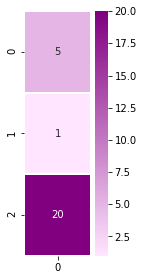

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Let's visualize our decoder hidden state
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [4]:
annotation = [3,12,45] #e.g. Encoder hidden state

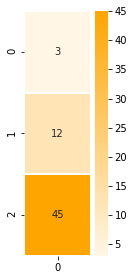

In [5]:
# Let's visualize the single annotation
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### IMPLEMENT: Scoring a Single Annotation
Let's calculate the dot product of a single annotation. Numpy's [dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) is a good candidate for this operation

In [6]:
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    # TODO: return the dot product of the two vectors
    return np.dot(dec_hidden_state, enc_hidden_state)
    
single_dot_attention_score(dec_hidden_state, annotation)

927

### Annotations Matrix
Let's now look at scoring all the annotations at once. To do that, here's our annotation matrix:

In [7]:
annotations = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])

And it can be visualized like this (each column is a hidden state of an encoder time step):

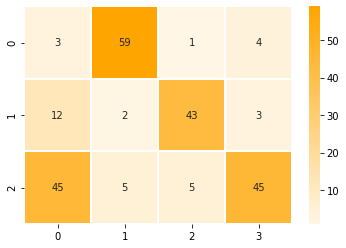

In [8]:
# Let's visualize our annotation (each column is an annotation)
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

### Scoring All Annotations at Once
Let's calculate the scores of all the annotations in one step using matrix multiplication. Let's continue to us the dot scoring method


$$\text{score}\left(h_t,  \overline{h}_s\right) = 
\begin{cases}
    h^T_t\overline{h}_s       &  \quad \text{dot}\\
    h^T_t W_a\overline{h}_s  & \quad \text{general } \\
    v_a\tanh\left(W_a [h^T_t, \overline{h}_s] \right) & \quad \text{concat }
  \end{cases}$$



To do that, we'll have to transpose `dec_hidden_state` and [matrix multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html) it with `annotations`.

In [9]:
def dot_attention_score(dec_hidden_state, annotations):
    # TODO: return the product of dec_hidden_state transpose and enc_hidden_states
    return np.matmul(np.transpose(dec_hidden_state), annotations)
    
attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

array([927., 397., 148., 929.])

Looking at these scores, can you guess which of the four vectors will get the most attention from the decoder at this time step?

## Softmax
Now that we have our scores, let's apply softmax:


$$ \begin{align} \alpha_t(s) & = \text{align}\left(h_t,  \overline{h}_s\right)  \\  & = \frac{\text{score}(h_t,  \overline{h}_s)}{\sum_{s'} \text{score}(h_t,  \overline{h}_{s'})}  \end{align}      $$

In [10]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) 

attention_weights = softmax(attention_weights_raw)
attention_weights

array([1.19202922e-001, 7.94715151e-232, 5.76614420e-340, 8.80797078e-001],
      dtype=float128)

Even when knowing which annotation will get the most focus, it's interesting to see how drastic softmax makes the end score become. The first and last annotation had the respective scores of 927 and 929. But after softmax, the attention they'll get is 0.119 and 0.880 respectively.

# Applying the scores back on the annotations
Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells)

$$ c_i = \sum_{j=1}^T \alpha_{ij} h_j  $$

In [11]:
def apply_attention_scores(attention_weights, annotations):
    # TODO: Multiple the annotations by their weights
    return attention_weights * annotations

applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

Let's visualize how the context vector looks now that we've applied the attention scores back on it:

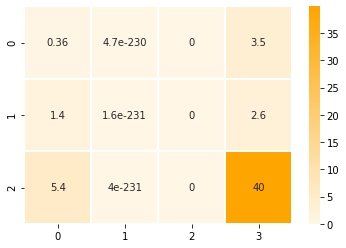

In [12]:
# Let's visualize our annotations after applying attention to them
ax = sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the second and third annotations (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

# Calculating the Attention Context Vector
All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector

In [13]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.88079708,  4.0728263 , 45.26423912], dtype=float128)

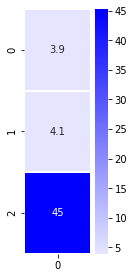

In [14]:
# Let's visualize the attention context vector
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1)

Now that we have the context vector, we can concatinate it with the hidden state and pass it through a hidden layer to produce the the result of this decoding time step.

# Part III : [Image Captioning](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph.

It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order. Recently, deep learning methods have achieved state-of-the-art results on examples of this problem.

What is most impressive about these methods is a single end-to-end model can be defined to predict a caption, given a photo, instead of requiring sophisticated data preparation or a pipeline of specifically designed models.

In this section, you will discover how to develop a photo captioning deep learning model from scratch.

After completing this section, you will know:

- How to prepare photo and text data for training a deep learning model.

- How to design and train a deep learning caption generation model.

- How to evaluate a trained caption generation model and use it to caption entirely new photographs.


In [1]:
import tensorflow
print(tensorflow.keras.__version__)

2.4.0


## Photo and Caption Dataset

A good dataset to use when getting started with image captioning is the __Flickr8K__ dataset.

The reason is because it is realistic and relatively small so that you can download it and build models on your workstation using a CPU.

The definitive description of the dataset is in the paper _“Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics”_ from 2013.

The authors describe the dataset as follows:

_We introduce a new benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events._

The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations. Here are some direct download links:

- [__Flickr8k_Dataset.zip__](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip) (1 Gigabyte) An archive of all photographs
- [__Flickr8k_text.zip__](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip) (2.2 Megabytes) An archive of all text descriptions for photographs.


Download the datasets and unzip them into your current working directory (directory of Jupyter Notebook). 
You will have two directories:

- __Flickr8k_Dataset__: Contains 8092 photographs in JPEG format.
- __Flickr8k_text__: Contains a number of files containing different sources of descriptions for the photographs.

The dataset has a pre-defined training dataset (6,000 images), validation dataset (1,000 images), and test dataset (1,000 images).

One measure that can be used to evaluate the skill of the model are BLEU scores. For reference, below are some ball-park BLEU scores for skillful models when evaluated on the test dataset (taken from the 2017 paper [“Where to put the Image in an Image Caption Generator“](https://arxiv.org/abs/1703.09137)):

- BLEU-1: 0.401 to 0.578.
- BLEU-2: 0.176 to 0.390.
- BLEU-3: 0.099 to 0.260.
- BLEU-4: 0.059 to 0.170.

We describe the BLEU metric more later when we work on evaluating our model.

Next, let’s look at how to load the images.

## Prepare Photo Data

We will use a pre-trained model to interpret the content of the photos.

There are many models to choose from. In this case, we will use the Oxford Visual Geometry Group, or VGG, model that won the ImageNet competition in 2014. Learn more about the model here:

[Very Deep Convolutional Networks for Large-Scale Visual Recognition](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)

Keras provides this pre-trained model directly. Note, the first time you use this model, Keras will download the model weights from the Internet, which are about 500 Megabytes. This may take a few minutes depending on your internet connection.

We could use this model as part of a broader image caption model. The problem is, it is a large model and running each photo through the network every time we want to test a new language model configuration (downstream) is redundant.

Instead, we can pre-compute the “photo features” using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset. It is no different to running the photo through the full VGG model; it is just we will have done it once in advance.

This is an optimization that will make training our models faster and consume less memory.

We can load the VGG model in Keras using the VGG class. We will remove the last layer from the loaded model, as this is the model used to predict a classification for a photo. We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. These are the “features” that the model has extracted from the photo.

Keras also provides tools for reshaping the loaded photo into the preferred size for the model (e.g. 3 channel 224 x 224 pixel image).

Below is a function named `extract_features` that, given a directory name, will load each photo, prepare it for VGG, and collect the predicted features from the VGG model. The image features are a 1-dimensional 4,096 element vector.

The function returns a dictionary of image identifier to image features.

We can call this function to prepare the photo data for testing our models, then save the resulting dictionary to a file named `‘features.pkl‘`.

The complete example is listed below. 

In [1]:
from os import listdir
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
 
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        #print('>%s' % name)
    return features
 
# extract features from all images
directory = 'Flicker8k_Dataset/'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('./features.pkl', 'wb'))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Running this data preparation step may take a while depending on your hardware, perhaps one hour on the CPU with a modern workstation.

At the end of the run, you will have the extracted features stored in `‘features.pkl‘` for later use. This file will be about 127 Megabytes in size. You can download it from Ilias.

## Prepare Text Data

The dataset contains multiple descriptions for each photograph and the text of the descriptions requires some minimal cleaning.

First, we will load the file containing all of the descriptions.

In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = './Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


Each photo has a unique identifier. This identifier is used on the photo filename and in the text file of descriptions.

Next, we will step through the list of photo descriptions. Below defines a function `load_descriptions()` that, given the loaded document text, will return a dictionary of photo identifiers to descriptions. Each photo identifier maps to a list of one or more textual descriptions.

In [3]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print(descriptions['1000268201_693b08cb0e'])
print('Loaded: %d ' % len(descriptions))

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Loaded: 8092 


Next, we need to clean the description text. The descriptions are already tokenized and easy to work with.

We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

- Convert all words to lowercase
- Remove all punctuation
- Remove all words that are one character or less in length (e.g. ‘a’)
- Remove all words with numbers in them

Below defines the `clean_descriptions()` function that, given the dictionary of image identifiers to descriptions, steps through each description and cleans the text.

In [4]:
import string
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
 
# clean descriptions
clean_descriptions(descriptions)
print(descriptions['1000268201_693b08cb0e'])

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


Once cleaned, we can summarize the size of the vocabulary.

Ideally, we want a vocabulary that is both expressive and as small as possible. A smaller vocabulary will result in a smaller model that will train faster.

For reference, we can transform the clean descriptions into a set and print its size to get an idea of the size of our dataset vocabulary.

In [23]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


Finally, we can save the dictionary of image identifiers and descriptions to a new file named _descriptions.txt_, with one image identifier and description per line.

Below defines the `save_descriptions()` function that, given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file.

In [24]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

Putting this all together, the complete listing is provided below.

Running the example first prints the number of loaded photo descriptions (8,092) and the size of the clean vocabulary (8,763 words).

Finally, the clean descriptions are written to _descriptions.txt_.

Taking a look at the file, we can see that the descriptions are ready for modeling. The order of descriptions in your file may vary.

## Develop Deep Learning Model

In this section, we will define the deep learning model and fit it on the training dataset.

This section is divided into the following parts:

- Loading Data
- Defining the Model
- Fitting the Model
- Complete Example

### Loading Data

First, we must load the prepared photo and text data so that we can use it to fit the model.

We are going to train the data on all of the photos and captions in the training dataset. While training, we are going to monitor the performance of the model on the validation dataset and use that performance to decide when to save models to file.

The train and validation dataset have been predefined in the `Flickr_8k.trainImages.txt` and `Flickr_8k.devImages.txt` files respectively, that both contain lists of photo file names. From these file names, we can extract the photo identifiers and use these identifiers to filter photos and descriptions for each set.

The function `load_set()` below will load a pre-defined set of identifiers given the train or validation sets filename.

In [25]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

Now, we can load the photos and descriptions using the pre-defined set of training or validation identifiers.

Below is the function `load_clean_descriptions()` that loads the cleaned text descriptions from _descriptions.txt_ for a given set of identifiers and returns a dictionary of identifiers to lists of text descriptions.

The model we will develop will generate a caption given a photo, and the caption will be generated one word at a time. The sequence of previously generated words will be provided as input. Therefore, we will need a 'first word' to kick-off the generation process and a 'last word' to signal the end of the caption.

We will use the strings `'startseq'` and `'endseq'` for this purpose. These tokens are added to the loaded descriptions as they are loaded. It is important to do this now before we encode the text so that the tokens are also encoded correctly.

In [26]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

Next, we can load the photo features for a given dataset.

Below defines a function named `load_photo_features()` that loads the entire set of photo descriptions, then returns the subset of interest for a given set of photo identifiers.

This is not very efficient; nevertheless, this will get us up and running quickly.

In [27]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

We can pause here and test everything developed so far.


In [28]:
from pickle import load
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


Running this example first loads the 6,000 photo identifiers in the test dataset. These features are then used to filter and load the cleaned description text and the pre-computed photo features.

We are nearly there.

The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the `Tokenizer` class that can learn this mapping from the loaded description data.

Below defines the `to_lines()` to convert the dictionary of descriptions into a list of strings and the `create_tokenizer()` function that will fit a Tokenizer given the loaded photo description text.

In [29]:
from keras.preprocessing.text import Tokenizer
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


We can now encode the text.

Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained.

For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:

Later, when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

The function below named `create_sequences()`, given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.

The input text is encoded as integers, which will be fed to a word embedding layer. The photo features will be fed directly to another part of the model. The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.

In [49]:
# create sequences of images, input sequences and output words for an image
import numpy as np
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

We will need to calculate the maximum number of words in the longest description. A short helper function named `max_length()` is defined below.

In [51]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

We now have enough to load the data for the training and development datasets and transform the loaded data into input-output pairs for fitting a deep learning model.

In [52]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# train dataset

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %i' % max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [53]:
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [54]:
# dev dataset

# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


### Defining the Model

We will define a deep learning based on the “merge-model” described by Marc Tanti, et al. in their 2017 papers:

- [Where to put the Image in an Image Caption Generator, 2017.](https://arxiv.org/abs/1703.09137)
- [What is the Role of Recurrent Neural Networks (RNNs) in an Image Caption Generator?, 2017.](https://arxiv.org/abs/1708.02043)

For a gentle introduction to this architecture, see the post:

- [Caption Generation with the Inject and Merge Architectures for the Encoder-Decoder Model](https://machinelearningmastery.com/caption-generation-inject-merge-architectures-encoder-decoder-model/)

The authors provide a nice schematic of the model, reproduced below.

<img src="./Bilder/schematic_image_captioning.png" width="600">


We will describe the model in three parts:

- __Photo Feature Extractor.__ This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
- __Sequence Processor.__ This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.
- __Decoder__ (for lack of a better name). Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.

The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

The function below named `define_model()` defines and returns the model ready to be fit.

In [63]:
# define the captioning model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

To get a sense for the structure of the model, specifically the shapes of the layers, see the summary listed below.

In [64]:
# define the model
model = define_model(vocab_size, max_length)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_4[0][0]                    
_______________________________________________________________________________________

Running the example first prints a summary of the loaded training and development datasets.



We also create a plot to visualize the structure of the network that better helps understand the two streams of input.
Plot of the Caption Generation Deep Learning Model

<img src="./Bilder/model.png" width="600">



### Fitting the Model

Now that we know how to define the model, we can fit it on the training dataset.

The model learns fast and quickly overfits the training dataset. For this reason, we will monitor the skill of the trained model on the holdout validation dataset. When the skill of the model on the validation dataset improves at the end of an epoch, we will save the whole model to file.

At the end of the run, we can then use the saved model with the best skill on the training dataset as our final model.

We can do this by defining a `ModelCheckpoint` in Keras and specifying it to monitor the minimum loss on the validation dataset and save the model to a file that has both the training and validation loss in the filename.

In [65]:
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

We can then specify the checkpoint in the call to `fit()` via the callbacks argument. We must also specify the development dataset in `fit()` via the validation_data argument.

We will only fit the model for 20 epochs, but given the amount of training data, each epoch may take 30 minutes on modern hardware.

In [66]:
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Epoch 1/20

Epoch 00001: val_loss improved from inf to 4.05935, saving model to model-ep001-loss4.524-val_loss4.059.h5
9576/9576 - 1003s - loss: 4.5237 - val_loss: 4.0593
Epoch 2/20

Epoch 00002: val_loss improved from 4.05935 to 3.89808, saving model to model-ep002-loss3.853-val_loss3.898.h5
9576/9576 - 972s - loss: 3.8530 - val_loss: 3.8981
Epoch 3/20

Epoch 00003: val_loss improved from 3.89808 to 3.88203, saving model to model-ep003-loss3.644-val_loss3.882.h5
9576/9576 - 966s - loss: 3.6441 - val_loss: 3.8820
Epoch 4/20

Epoch 00004: val_loss improved from 3.88203 to 3.87302, saving model to model-ep004-loss3.540-val_loss3.873.h5
9576/9576 - 968s - loss: 3.5405 - val_loss: 3.8730
Epoch 5/20

Epoch 00005: val_loss did not improve from 3.87302
9576/9576 - 965s - loss: 3.4794 - val_loss: 3.8927
Epoch 6/20

Epoch 00006: val_loss did not improve from 3.87302
9576/9576 - 965s - loss: 3.4412 - val_loss: 3.9221
Epoch 7/20

Epoch 00007: val_loss did not improve from 3.87302
9576/9576 - 965s



After the summary of the model, we can get an idea of the total number of training and validation (development) input-output pairs.

Train on 306,404 samples, validate on 50,903 samples

The model then runs, saving the best model to .h5 files along the way.

On my run, the best validation results were saved to the file:

- __model-ep002-loss3.245-val_loss3.612.h5__

This model was saved at the end of epoch 2 with a loss of 3.245 on the training dataset and a loss of 3.612 on the validation dataset

Your specific results will vary.


Did you get an error like:

Then run it on Colab or run the following code:

## Evaluate Model

Once the model is fit, we can evaluate the skill of its predictions on the holdout test dataset.

We will evaluate a model by generating descriptions for all photos in the test dataset and evaluating those predictions with a standard cost function.

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token `‘startseq‘`, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached ‘endseq‘ or the maximum description length is reached.

The function below named `generate_desc()` implements this behavior and generates a textual description given a trained model, and a given prepared photo as input. It calls the function `word_for_id()` in order to map an integer prediction back to a word.

In [68]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

We will generate predictions for all photos in the test dataset and in the train dataset.

The function below named `evaluate_model()` will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [69]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU scores are used in text translation for evaluating translated text against one or more reference translations.

Here, we compare each generated description against all of the reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.

You can learn more about the BLEU score here:

- [A Gentle Introduction to Calculating the BLEU Score for Text in Python](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)

The [NLTK Python library implements the BLEU score calculation](http://www.nltk.org/api/nltk.translate.html) in the `corpus_bleu()` function. A higher score close to 1.0 is better, a score closer to zero is worse.

We can put all of this together with the functions from the previous section for loading the data. We first need to load the training dataset in order to prepare a Tokenizer so that we can encode generated words as input sequences for the model. It is critical that we encode the generated words using exactly the same encoding scheme as was used when training the model.

We then use these functions for loading the test dataset.

The complete example is listed below.

In [70]:
from numpy import argmax
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# prepare tokenizer on train set

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('./descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('./features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model; either the model with the smallest validiation loss
# or the model which was obtained
filename = 'model_19.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.537660
BLEU-2: 0.284404
BLEU-3: 0.190370
BLEU-4: 0.087817


Running the example prints the BLEU scores.

We can see that the scores fit within and close to the top of the expected range of a skillful model on the problem. The chosen model configuration is by no means optimized.

### Generate New Captions

Now that we know how to develop and evaluate a caption generation model, how can we use it?

Almost everything we need to generate captions for entirely new photographs is in the model file.

We also need the Tokenizer for encoding generated words for the model while generating a sequence, and the maximum length of input sequences, used when we defined the model (e.g. 34).

We can hard code the maximum sequence length. With the encoding of text, we can create the tokenizer and save it to a file so that we can load it quickly whenever we need it without needing the entire _Flickr8K_ dataset. An alternative would be to use our own vocabulary file and mapping to integers function during training.

We can create the Tokenizer as before and save it as a pickle file _tokenizer.pkl_. The complete example is listed below.

In [71]:
from tensorflow.keras.preprocessing.text import Tokenizer
from pickle import dump

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer_flickr.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


We can now load the tokenizer whenever we need it without having to load the entire training dataset of annotations.

Now, let’s generate a description for a new photograph.

Below is a new photograph from my photo album:

<img src="./Bilder/example_10.jpg" width="600">


We will generate a description for it using our model.

Download the photograph and save it to your local directory with the filename _example.jpg_.

First, we must load the Tokenizer from `tokenizer_flickr.pk` and define the maximum length of the sequence to generate, needed for padding inputs.

In [ ]:
# load the tokenizer
tokenizer = load(open('tokenizer_flickr.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34

Then we must load the model, as before.

In [ ]:
# load the model
model = load_model('model_19.h5')

Next, we must load the photo from which we want to describe and extract the features.

We could do this by re-defining the model and adding the VGG-16 model to it, or we can use the VGG model to predict the features and use them as inputs to our existing model. We will do the latter and use a modified version of the `extract_features()` function used during data preparation, but adapted to work on a single photo.

In [ ]:
from PIL import Image
from pickle import load
from numpy import argmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# load and prepare the photograph
photo = extract_features('./Bilder/example_10.jp2')
print(photo.shape)

We can then generate a description using the `generate_desc()` function defined when evaluating the model.

The complete example for generating a description for an entirely new standalone photograph is listed below.

In [73]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# load the tokenizer
tokenizer = load(open('tokenizer_flickr.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model_19.h5')
# load and prepare the photograph
photo = extract_features('./Bilder/example_10.jp2')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man climbs rock face endseq


In this case, the description generated was as follows:

startseq man climbs rock face endseq

You could remove the start and end tokens and you would have the basis for a nice automatic photo captioning model.



### Extensions for Your Course Project

This section lists some ideas for extending the tutorial that you may wish to explore.

- Alternate Pre-Trained Photo Models. A small 16-layer VGG model was used for feature extraction. Consider exploring larger models that offer better performance on the ImageNet dataset, such as Inception or EfficientNet.
    
- Smaller Vocabulary. A larger vocabulary of nearly eight thousand words was used in the development of the model. Many of the words supported may be misspellings or only used once in the entire dataset. Refine the vocabulary and reduce the size, perhaps by half.
    
- Pre-trained Word Vectors. The model learned the word vectors as part of fitting the model. Better performance may be achieved by using word vectors either pre-trained on the training dataset or trained on a much larger corpus of text, such as news articles or Wikipedia.]()
    
- Tune Model. The configuration of the model was not tuned on the problem. Explore alternate configurations and see if you can achieve better performance.

- Get acquainted with the [Zalando fashion dataset](https://github.com/zalandoresearch/feidegger/) which is a multi-modal Corpus of fashion images and descriptions in german and train an image captioning model.


This section provides more resources on the topic if you are looking go deeper.

### Caption Generation Papers

- [Show and Tell: A Neural Image Caption Generator, 2015.](https://arxiv.org/abs/1411.4555)
- [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, 2015.](https://arxiv.org/abs/1502.03044)
- [Where to put the Image in an Image Caption Generator, 2017.](https://arxiv.org/abs/1703.09137)
- [What is the Role of Recurrent Neural Networks (RNNs) in an Image Caption Generator?, 2017.](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)
- [Automatic Description Generation from Images: A Survey of Models, Datasets, and Evaluation Measures, 2016.](https://arxiv.org/abs/1601.03896)


# Part IV : Image Captioning with Visual Attention


Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![alt text](./surf.jpg "Title")

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.


![alt text](./imcap_prediction.png "Title")


The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions for about 20,000 images (because there are multiple captions per image in the dataset).

In [63]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

__Caution: large download ahead__. You'll use the training set, which is a 13GB file.

In [64]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

## Optional: limit the size of the training set

To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [65]:
# Read the json file
annotation_file = './annotations/captions_train2014.json'

with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [66]:
len(train_captions), len(all_captions)

(30000, 414113)

## Preprocess the images using InceptionV3

Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:

- Resizing the image to 299px by 299px
- [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [67]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

- You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
- After all the images are passed through the network, you pickle the dictionary and save it to disk.

In [68]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can:

1. install tqdm:

`!pip install -q tqdm`

2. Import tqdm:

`from tqdm import tqdm`

3. Change the following line:

`for img, path in image_dataset:`

to:

`for img, path in tqdm(image_dataset):`

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

# Preprocess and tokenize the captions

- First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
- Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
- You then create word-to-index and index-to-word mappings.
- Finally, you pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [ ]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

### Create a tf.data dataset for training

Our images and captions are ready! Next, let's create a `tf.data dataset` to use for training our model.

In [54]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model
Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell paper](https://arxiv.org/pdf/1502.03044.pdf).

- In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
- You squash that to a shape of (64, 2048).
- This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
- The RNN (here GRU) attends over the image to predict the next word.

In [57]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
    
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoint

In [58]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

- You extract the features stored in the respective .npy files and then pass those features through the encoder.
- The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
- The decoder returns the predictions and the decoder hidden state.
- The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
- Use teacher forcing to decide the next input to the decoder.
- Teacher forcing is the technique where the target word is passed as the next input to the decoder.
- The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

Epoch 2 Batch 0 Loss 0.8581
Epoch 2 Batch 100 Loss 0.8342
Epoch 2 Batch 200 Loss 0.7610
Epoch 2 Batch 300 Loss 0.7606
Epoch 2 Loss 0.796188
Time taken for 1 epoch 982.328290939331 sec

Epoch 3 Batch 0 Loss 0.7785
Epoch 3 Batch 100 Loss 0.7223
Epoch 3 Batch 200 Loss 0.7343
Epoch 3 Batch 300 Loss 0.7207
Epoch 3 Loss 0.725883
Time taken for 1 epoch 958.1319239139557 sec

Epoch 4 Batch 0 Loss 0.6941
Epoch 4 Batch 100 Loss 0.7522
Epoch 4 Batch 200 Loss 0.6781
Epoch 4 Batch 300 Loss 0.6673
Epoch 4 Loss 0.681024
Time taken for 1 epoch 967.0104069709778 sec

Epoch 5 Batch 0 Loss 0.5829
Epoch 5 Batch 100 Loss 0.6536
Epoch 5 Batch 200 Loss 0.6460
Epoch 5 Batch 300 Loss 0.6390
Epoch 5 Loss 0.645679
Time taken for 1 epoch 945.3144369125366 sec

Epoch 6 Batch 0 Loss 0.6242
Epoch 6 Batch 100 Loss 0.6392
Epoch 6 Batch 200 Loss 0.5987
Epoch 6 Batch 300 Loss 0.5552
Epoch 6 Loss 0.614216
Time taken for 1 epoch 900.3698348999023 sec

Epoch 7 Batch 0 Loss 0.6127
Epoch 7 Batch 100 Loss 0.5677
Epoch 7 Batch

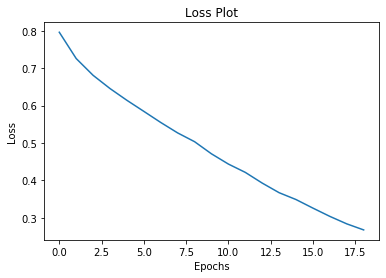

In [59]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()    

## Caption!

The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
Stop predicting when the model predicts the end token.
And store the attention weights for every time step.

Real Caption: <start> a group of elephants in an outdoor enclosure <end>
Prediction Caption: three elephants standing next to some elephants <end>


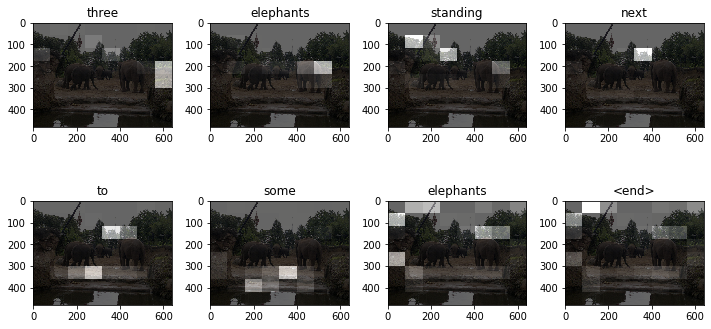

In [60]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()
    
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)



##  Try it on your own images

For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)

Prediction Caption: a man in glasses and yellow tie <unk> <end>


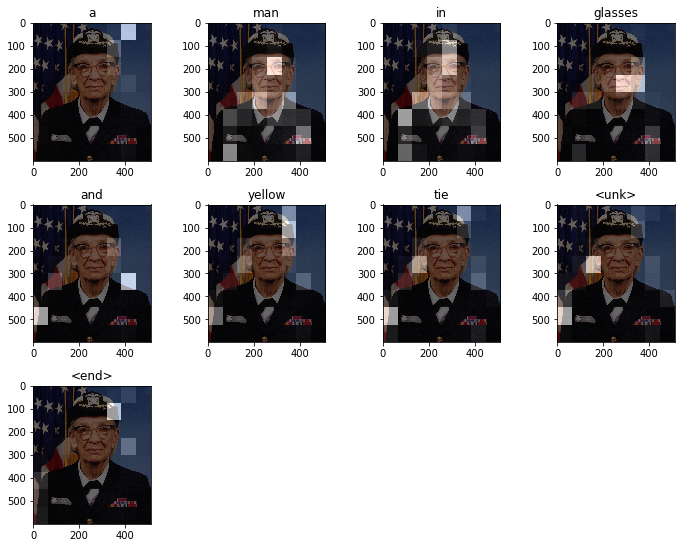

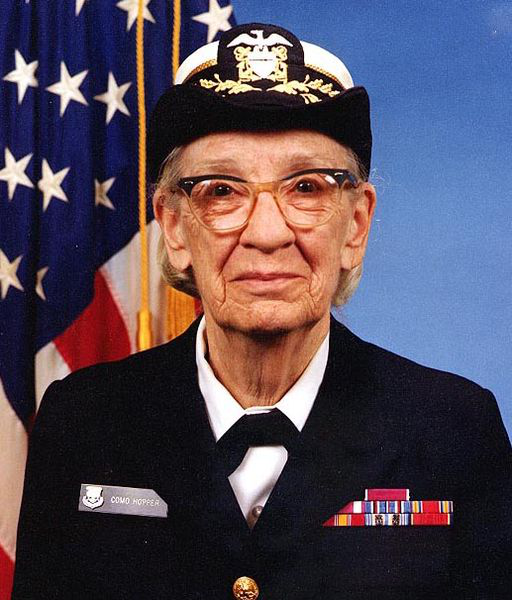

In [61]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a dog riding a horse over and skis <end>


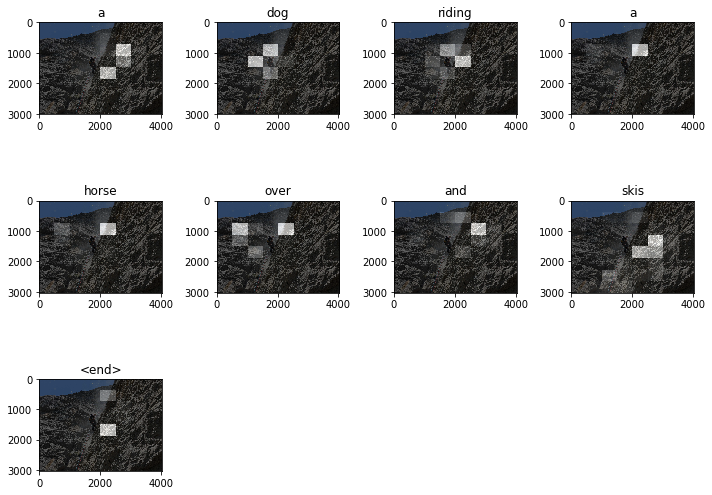

In [76]:
image = './Bilder/example_10.jpg'
result, attention_plot = evaluate(image)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
